In [49]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt



# Random forest #####################################

from sklearn.model_selection import train_test_split,cross_val_score,  GridSearchCV, KFold, StratifiedKFold, RandomizedSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score

######################################################



# Redes neuronales ###################################

from sklearn import model_selection
from sklearn.metrics import confusion_matrix

import tensorflow.keras as keras
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, Conv1D, Conv2D, MaxPooling1D, MaxPooling2D, Lambda, MaxPool2D, BatchNormalization
#from keras.utils import np_utils

import tensorflow as tf
from tensorflow.keras import models, layers, optimizers
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.utils import class_weight

from tensorflow.keras.optimizers import SGD, RMSprop, Adam, Adagrad, Adadelta, RMSprop, Nadam, Adamax
from tensorflow.keras.models import Sequential, model_from_json
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras import backend as K
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.models import Model

from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, label_ranking_average_precision_score, label_ranking_loss, coverage_error 
import itertools

from tensorflow.keras.callbacks import EarlyStopping

########################################################
import os
from sklearn import metrics

In [50]:
os.environ['CUDA_DEVICE_ORDER']    ='PCI_BUS_ID'
os.environ['CUDA_VISIBLE_DEVICES'] = '0,1,2,3'
os.environ['TF_FORCE_GPU_ALLOW_GROWTH'] = 'true'

In [51]:
df = pd.read_csv("data_opt_Feline_clean.csv", header = 0)
df.head()

,Unnamed: 0,ID,Fe/H,T,Spec_Type,logG,3.636,3.6361,3.6362,3.6363,...,3.647,3.6471,3.6472,3.6473,3.6474,3.6475,3.6476,3.6477,3.6478,3.6479
0,0,299493250387961856,-1.114146,8123.4950,A0,4.231899,0.727069,0.659317,0.698580,0.753081,...,0.906805,0.920526,0.845230,0.824348,0.826020,0.900767,0.934351,0.823357,0.814464,0.881975
1,1,299497098678659072,0.022925,6082.7534,F2,3.811555,0.710345,0.673832,0.688650,0.774810,...,0.781177,0.810640,0.878742,0.916780,0.959738,0.902997,0.834681,0.787898,0.783533,0.840650
2,2,299498198190286848,-0.956672,5824.9960,G2,3.762244,0.767890,0.745628,0.713973,0.716306,...,0.870743,0.903982,0.911388,0.920946,0.981157,1.000000,0.974021,0.946377,0.872897,0.835844
3,3,299500672091449344,-0.086240,6894.1313,F5,4.002970,0.873480,0.830938,0.788394,0.822818,...,0.887271,0.889910,0.929657,0.977077,1.000000,0.981194,0.943684,0.907632,0.870985,0.870356
4,4,299501771603077120,-2.075622,6292.1630,F5,3.642724,0.946972,0.927313,0.927848,0.939332,...,0.966774,0.954011,0.966556,0.954604,0.941863,0.969388,0.972256,0.950652,0.959544,0.959670


In [52]:
from sklearn.model_selection import train_test_split

X = df.drop(["ID", "T", "Fe/H","Spec_Type", "logG"], axis = 1)
Y_temp = df["T"] 
Y_fe_h = df["Fe/H"] 
Y_g = df["logG"] 

#Y_temp = Y_temp.apply(lambda x: x/x.max(), axis = 1)
#print("La temperatura máxima es ", Y_temp.max(), ". Los valores se normalizaron respecto a ese valor.") # 9088.135 K para visible, 7252.624 K para IR



In [53]:
Y_temp = Y_temp.divide(Y_temp.max())
X_train, X_test, y_T_train, y_T_test = train_test_split(X, Y_temp, test_size=0.20, random_state=42)

In [54]:
Y_fe_h = Y_fe_h.divide(Y_fe_h.max())
X_train, X_test, y_fe_h_train, y_fe_h_test = train_test_split(X, Y_fe_h, test_size=0.20, random_state=42)

In [55]:
 Y_g =  Y_g.divide( Y_g.max())
X_train, X_test, y_g_train, y_g_test = train_test_split(X, Y_g, test_size=0.20, random_state=42)

Elegir la característica a predecir:

In [56]:
possible_Y = {1 : y_T_train, 2 : y_fe_h_train, 3 : y_g_train}
possible_test_Y = {1 : y_T_test, 2 : y_fe_h_test, 3 : y_g_test}

y_train = possible_Y[2]       # Seleccionar número para elegir qué característica predecir. 
y_test = possible_test_Y[2]   # Seleccionar número para elegir qué característica predecir.

Cosas que hay que probar para optimizar el modelo de red neuronal:

* El atributo "paciencia" de la parada prematura, para valores de "paciencia" menores que 5.

* El tamaño del conjunto de test, para valores menores de 50%.

* La función de activación para las capas ocultas, entre los valores "elu", "relu", "selu", "sigmoid" y "tanh".

* La función de activación para la penúltima capa, entre los valores "elu", "relu", "selu", "sigmoid" y "tanh".

* La función de activación para la última capa, entre los valores "elu", "relu" y "selu".

* Selección del optimizador de la red neuronal, para los optimizadores "Adam", "Adamax" y "Nadam".



# MLP

In [57]:
num_features = X.shape[1]
dropout=0.3
batch_size = 128       # Esto hay que cambiarlo a números mucho más grandes cuando tengamos todos los datos. 
layers_dim=[128, 128, 128, 128]
inputs = keras.Input(shape=(num_features,))
x = layers.Reshape((num_features,))(inputs)
for d in layers_dim:
    x = layers.Dense(d, activation=tf.nn.leaky_relu)(x)
    x = layers.Dropout(rate=dropout)(x)
out_mlp = layers.Dense(1)(x)
Model = keras.Model(inputs=[inputs], outputs=[out_mlp])
Model.summary()

Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 121)]             0         
_________________________________________________________________
reshape_3 (Reshape)          (None, 121)               0         
_________________________________________________________________
dense_15 (Dense)             (None, 128)               15616     
_________________________________________________________________
dropout_12 (Dropout)         (None, 128)               0         
_________________________________________________________________
dense_16 (Dense)             (None, 128)               16512     
_________________________________________________________________
dropout_13 (Dropout)         (None, 128)               0         
_________________________________________________________________
dense_17 (Dense)             (None, 128)               1651

In [58]:
a = keras.optimizers.Adam(lr=0.0005, decay=0.0001)
Model.compile(optimizer=a,
                loss=['mse'],
                loss_weights=[1],
                metrics=[keras.metrics.RootMeanSquaredError()])
paciencia = 3 # 3
#callbacks = EarlyStopping(monitor='loss', patience=paciencia)
callbacks = []

Model.fit(X_train, y_train, batch_size=batch_size, epochs=1000, callbacks=callbacks, validation_split=0.2)

Epoch 1/1000
249/249 [==============================] - 1s 4ms/step - loss: 195714.4531 - root_mean_squared_error: 442.3963 - val_loss: 7.8387 - val_root_mean_squared_error: 2.7998
Epoch 2/1000
249/249 [==============================] - 1s 4ms/step - loss: 20617.9707 - root_mean_squared_error: 143.5896 - val_loss: 141.1220 - val_root_mean_squared_error: 11.8795
Epoch 3/1000
249/249 [==============================] - 1s 4ms/step - loss: 10125.7363 - root_mean_squared_error: 100.6267 - val_loss: 39.6272 - val_root_mean_squared_error: 6.2950
Epoch 4/1000
249/249 [==============================] - 1s 4ms/step - loss: 6495.1514 - root_mean_squared_error: 80.5925 - val_loss: 103.0643 - val_root_mean_squared_error: 10.1521
Epoch 5/1000
249/249 [==============================] - 1s 4ms/step - loss: 4627.1821 - root_mean_squared_error: 68.0234 - val_loss: 13.4629 - val_root_mean_squared_error: 3.6692
Epoch 6/1000
249/249 [==============================] - 1s 4ms/step - loss: 3459.1475 - root_me

In [59]:
y_pred = Model.predict(X_test)
y_pred = pd.Series(y_pred[:,0])
y_pred = y_pred.multiply(df["Fe/H"].max())
y_true = y_test.multiply(df["Fe/H"].max())

print([type(y_pred),type(y_true),y_pred.shape,y_true.shape])

ae = np.mean(abs(y_true[:]-y_pred[:]))
pe = np.mean(abs(y_true[:]-y_pred[:]) / y_true[:])
rmse = np.sqrt(metrics.mean_squared_error(y_true[:], y_pred[:]))
resid_mean = np.mean(y_true[:]-y_pred[:])
resid_sd = np.std(y_true[:]-y_pred[:])
r2 = metrics.r2_score(y_true[:],y_pred[:])


[<class 'pandas.core.series.Series'>, <class 'pandas.core.series.Series'>, (9929,), (9929,)]


In [60]:
print(ae)
print(pe)
print(rmse)
print(resid_mean)
print(resid_sd)
print(r2)

0.5922834674553611
-0.20390177995043643
0.4175327960656443
-0.12327878742406088
0.7668478729996816
0.5782636578601292


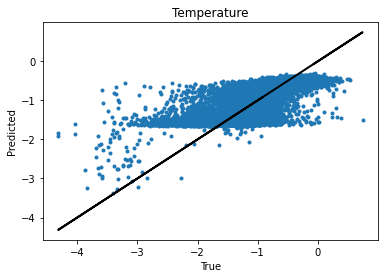

In [61]:
plt.plot(y_true,y_pred,'.')
plt.plot(y_true, y_true, color='k', linestyle='-', linewidth=2)
plt.ylabel('Predicted')
plt.xlabel('True')
plt.title('Temperature')
plt.show()

# NN ALONSO

In [ ]:
# Parámetros #####################
signal_length = X.shape[1]
n_classes = 1
batch_size = 128       # Esto hay que cambiarlo a números mucho más grandes cuando tengamos todos los datos. 
paciencia = 3 # 3
dropout = 0.3

layer_acti = "tanh"

##################################


model = Sequential()

# Añadimos parada temprana para evitar el overfitting: ################
callbacks = EarlyStopping(monitor='loss', patience=paciencia)
#######################################################################

model.add(Dense(signal_length, activation=layer_acti))
model.add(Dropout(dropout))

model.add(Dense(250, activation=layer_acti))
model.add(Dropout(dropout))

model.add(Flatten())

model.add(Dense(75, activation=layer_acti))
model.add(Dropout(dropout))

model.add(Dense(10, activation=layer_acti))
model.add(Dropout(dropout))


model.add(Dense(1, activation=layer_acti))
model.add(Dropout(dropout))

#model = keras.Model(inputs=X_train, outputs=y_train)
#model.summary()

In [ ]:
# Expandir dimensiones de los arrays para que encajen en la forma necesaria para la red neuronal:
X_train_exp = np.expand_dims(X_train, axis=2)
X_test_exp = np.expand_dims(X_test, axis=2)
#################################################################################################

model.compile(loss='mean_squared_error', optimizer=Adam(), metrics=[keras.metrics.RootMeanSquaredError()])#'mean_squared_error'])

In [ ]:
#history = model.fit(X_train_exp, y_train, epochs=75, batch_size=batch_size, verbose=1, validation_data=(X_test_exp, y_test), callbacks=[callback])
model.fit(X_train_exp, y_train, epochs=75, batch_size=batch_size, verbose=1, validation_split=0.2, callbacks=[callbacks])


In [ ]:
y_pred = model.predict(X_test_exp)
y_pred = pd.Series(y_pred[:,0])
y_pred = y_pred.multiply(df["T"].max())
y_true = y_test.multiply(df["T"].max())

ae = np.mean(abs(y_true[:]-y_pred[:]))
pe = np.mean(abs(y_true[:]-y_pred[:]) / y_true[:])
rmse = np.sqrt(metrics.mean_squared_error(y_true[:], y_pred[:]))

print([type(y_pred),type(y_true),y_pred.shape,y_true.shape])

In [ ]:
print(ae)
print(pe)
print(rmse)

In [ ]:
plt.plot(y_true,y_pred,'.')
plt.plot(y_true, y_true, color='k', linestyle='-', linewidth=2)
plt.ylabel('Predicted')
plt.xlabel('True')
plt.title('Temperature')
plt.show()

In [ ]:
loss = history.history['loss']

epochs = range(1, len(loss)+1)
plt.plot(epochs, loss, 'ro', label='Training loss')
plt.legend()
plt.show()

In [ ]:
fig1, (ax0) = plt.subplots(ncols=1)

ax0.plot(range(len(history.history["accuracy"])), history.history["accuracy"], label = "Accuracy")
ax0.plot(range(len(history.history["val_accuracy"])), history.history["val_accuracy"], label = "Validation accuracy")
ax0.set_title("Accuracy y validation accuracy")
plt.xlabel("Epoch")
plt.ylabel("Value")
ax0.legend()

Cosas que hay que probar para optimizar el random forest:



*   Llevar a cabo el randomized search cross validation con la matriz de parámetros de la siguiente celda. 
*   Optimizar el número de características (longitudes de onda) menos importantes a recortar para mejorar la precisión del modelo (ver última celda). 



In [ ]:
param_grid = {
  'bootstrap':[True], # Hay que fijar esta variable en "True" porque si no siempre va a salir "False", porque eso le permite hacer overfitting. 
  'ccp_alpha':[0.0,0.5,1.0,1.5,2.0],
  'criterion':['mse', 'mae'],
  'max_depth':[None, 5, 8, 15, 20],
  'max_features':['auto', 'sqrt', 'log2'],
  'max_leaf_nodes':[None, 20, 50, 100, 150],
  'max_samples':[None, 1, 0.2, 0.4, 0.6, 0.8],
  'min_impurity_decrease':[0.0,0.5,1.0,1.5,2.0],
  'min_samples_leaf':[2,3,4,5],
  'min_samples_split':[2,3,4,5,6],
  'min_weight_fraction_leaf':[0.0,0.5],
  'oob_score':[True, False],
  'random_state':[42],
  'n_estimators':[100],
  'verbose':[1, 5, 20, 50, 100],
  'warm_start':[True, False]
  }

In [ ]:
rf = RandomForestRegressor()
rscv = RandomizedSearchCV(rf, param_grid)
search = rscv.fit(X_train, y_train)
best_params = search.best_params_

In [ ]:
print("The best parameters are", best_params)
#The best parameters are {'warm_start': False, 'verbose': 50, 'random_state': 42, 'oob_score': False, 'n_estimators': 100, 'min_weight_fraction_leaf': 0.0, 'min_samples_split': 6, 'min_samples_leaf': 3, 'min_impurity_decrease': 1.5, 'max_samples': 0.8, 'max_leaf_nodes': 20, 'max_features': 'sqrt', 'max_depth': 15, 'criterion': 'mae', 'ccp_alpha': 2.0, 'bootstrap': True}


In [ ]:
from sklearn.metrics import mean_squared_error, r2_score

rf_best = RandomForestRegressor()
rf_best.set_params(**best_params)
rf_best.fit(X_train, y_train)

y_pred = rf_best.predict(X_test)

# Ver características más importantes:
important_features_dict = {}
for idx, val in enumerate(rf_best.feature_importances_):
    important_features_dict[idx] = val

important_features_list = sorted(important_features_dict, key=important_features_dict.get, reverse=True)
print(important_features_list) # Los primeros valores de la lista son los menos importantes. 
#################################

print("The mean square error is ", mean_squared_error(y_test, y_pred), " and R^2 is ", r2_score(y_test, y_pred), ".")

In [ ]:
from sklearn.metrics import mean_squared_error, r2_score

# Número de columnas de datos/características (longitudes de onda) que cortar
number_of_features_to_cut = 2458 # Mejor valor de momento 2458
###########################################################


# Cortar las características menos importantes. 
features_to_cut = important_features_list[(len(important_features_list)-number_of_features_to_cut):] # Cortar las x características menos importantes.
X_train_cut = X_train.copy()
X_test_cut =  X_test.copy()

for f in features_to_cut:
  col = X_train.columns[f]
  X_train_cut.drop(col, axis=1, inplace=True)
  X_test_cut.drop(col, axis=1, inplace=True)
#################

rf_best2 = RandomForestRegressor()
rf_best2.set_params(**best_params)
rf_best2.fit(X_train_cut, y_train)

y_pred_2 = rf_best2.predict(X_test_cut)

print("The mean square error is ", mean_squared_error(y_test, y_pred_2), " and R^2 is ", r2_score(y_test, y_pred_2), ".")